## White-box attack exercise

In this exercise, you will implement the following white-box attacks.
1. Fast Gradient Sign Method (FGSM)
2. Projected Gradient Descent (PGD)

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n'
FOLDERNAME = "hw6_files"

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/My\ Drive/$FOLDERNAME/data
!bash download_data.sh
%cd ../models
!bash download_models.sh
%cd ..

Mounted at /content/drive
/content/drive/My Drive/hw6_files/data
------------------------------
Cifar-10 dataset already exits
------------------------------
/content/drive/My Drive/hw6_files/models
--------------------------------------
Naturally-trained model already exists
--------------------------------------
------------------------------------------
Adversarially-trained model already exists
------------------------------------------
/content/drive/My Drive/hw6_files


In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
tf.experimental.output_all_intermediates(True)
tf.disable_eager_execution()

from cifar10_input import CIFAR10Data
from model import Model

%load_ext autoreload
%autoreload 2

## Loading Cifar-10 test dataset

Loading Cifar-10 test dataset
The number of the test data: 10000


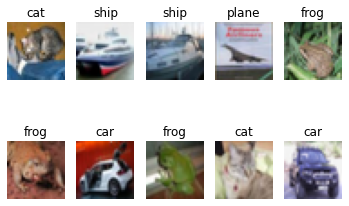

In [5]:
# Clear previously loaded data
try:
   del eval_data
   print('Clearing previously loaded data')
except:
   pass

# Load Cifar-10 test set
print('Loading Cifar-10 test dataset')
DATA_DIR = './data/cifar-10-batches-py'
eval_data = CIFAR10Data(DATA_DIR).eval_data

# Print the number of samples in the test set
print('The number of the test data: {}'.format(eval_data.n))

# Print the first 10 samples
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sample_image = eval_data.xs[i]
    sample_label = eval_data.ys[i]
    plt.imshow(sample_image.astype('uint8'))
    plt.axis('off')
    plt.title(classes[sample_label])

## Restoring a naturally-trained ResNet classifier

In [6]:
# Reset all graphs and session
print('Clearing all graphs')
tf.reset_default_graph()

# Create a naturally-trained model
print('Creating a ResNet model')
model = Model(mode='eval')
sess = tf.Session()

# Restore parameters
print('Restoring parameters')
NAT_MODEL_DIR = './models/naturally_trained'
model_file = tf.train.latest_checkpoint(NAT_MODEL_DIR)

var_list = {}
with tf.variable_scope('', reuse=True):
  for var in tf.train.list_variables(model_file)[1:]:
    if 'Momentum' not in var[0]:
      var_list[var[0]] = tf.get_variable(name=var[0].replace('BatchNorm', 'batch_normalization'))

saver = tf.train.Saver(var_list=var_list)
saver.restore(sess, model_file)

Clearing all graphs
Creating a ResNet model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Restoring parameters
INFO:tensorflow:Restoring parameters from ./models/naturally_trained/checkpoint-70000


## Evaluating the model

Before implementing attack methods, we have to evaluate the model for the following reasons.
1. To check whether the model is successfuly restored. 
2. To get samples that are correctly classified. We don't have to attack misclassified samples.

Note that the indices of the first 100 samples are stored in a variable named `correct_indices`. You will use it later.

In [7]:
def evaluate(model, sess, data, indices, attack_method=None):
    """
    Given the data specified by the indices, evaluate the model.
    
    Args:
        model: TensorFlow model
        sess: TensorFlow session
        data: Cifar-10 test dataset
        indices: Indices that specifies the data
        attack_method (optional): Instance of attack method, If it is not None, the attack method is applied before
        evaluation.
    
    Returns:
        correct_prediction: NumPy array with the same shape as the indices. Given an index, 1 if the corresponding
        sample is correctly classifed, 0 otherwise.
    """
    
    correct_predictions = np.zeros([0], np.int32)
    
    num_images = len(indices)
    batch_size = 100
    num_batches = int(math.ceil(num_images/batch_size))
    
    # Run batches
    for batch in range(num_batches):
        # Construct batch
        bstart = batch*batch_size
        bend = min(bstart+batch_size, num_images)
        image_batch = data.xs[indices[bstart:bend]]
        image_batch = np.int32(image_batch)
        label_batch = data.ys[indices[bstart:bend]]
        # Attack batch
        if attack_method is not None:
            image_batch = attack_method.perturb(image_batch, label_batch, sess)
        # Evaluate batch
        feed_dict = {
            model.x_input: image_batch, 
            model.y_input: label_batch
        }
        correct_prediction = sess.run(model.correct_prediction, feed_dict=feed_dict)
        correct_predictions = np.concatenate([correct_predictions, correct_prediction], axis=0)
    
    return correct_predictions

# Evaluate the naturally-trained model on the first 1000 samples in the test dataset
indices = np.arange(0, 1000)

print('Evaluating naturally-trained model')
correct_predictions = evaluate(model, sess, eval_data, indices)
accuracy = np.mean(correct_predictions)*100
print('Accuracy: {:.1f}%'.format(accuracy))

# Select the first 100 samples that are correctly classified.
correct_indices = np.where(correct_predictions==1)[0][:100]

Evaluating naturally-trained model
Accuracy: 96.2%


## Fast Gradient Sign Method (FGSM)

Now, you will implement Fast Gradient Sign Method under $\ell_{\infty}$ constraint, the first method of generating adversarial examples proposed by [Goodfellow et al.](https://arxiv.org/abs/1412.6572). The algorithm is as follows.

<center>$x_{adv} = x + \epsilon \cdot \text{sgn}(\nabla_{x} L(x, y, \theta))$</center>

where $x, y$ are an image and the corresponding label, $L$ is a loss function, and $\epsilon$ is a maximum perturbation. Usually, Cross-Entropy loss is used for $L$. However, there might be many possible choices for $L$, such as Carlini-Wagner loss (https://arxiv.org/abs/1608.04644)

Your code for this section will all be written inside `attacks/fgsm_attack.py`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


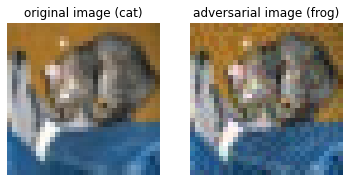

In [60]:
# First implement Fast Gradient Sign Method.
# Open attacks/fgsm_attack.py and follow instructions in the file.

from attacks.fgsm_attack import FGSMAttack

# Check if your implementation is correct.

# Default attack setting
epsilon = 8
loss_func = 'cw'

# Create an instance of FGSMAttack
fgsm_attack = FGSMAttack(model, epsilon, loss_func)

# Run FGSM attack on a sample
sample_image = eval_data.xs[correct_indices[0]]
sample_image = np.int32(sample_image) # please convert uint8 to int32
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = eval_data.ys[correct_indices[0]]
sample_label = np.expand_dims(sample_label, axis=0)
sample_adv_image = fgsm_attack.perturb(sample_image, sample_label, sess)
sample_adv_label = sess.run(model.predictions, feed_dict={model.x_input: sample_adv_image})

# Check if the adversarial image is valid
assert np.amax(np.abs(sample_image-sample_adv_image)) <= epsilon
assert np.amin(sample_adv_image) >= 0
assert np.amax(sample_adv_image) <= 255

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0, ...].astype('uint8'))
plt.axis('off')
plt.title('original image ({})'.format(classes[sample_label[0]]))

# Plot the adversarial image
plt.subplot(1, 2, 2)
plt.imshow(sample_adv_image[0, ...].astype('uint8'))
plt.axis('off')
plt.title('adversarial image ({})'.format(classes[sample_adv_label[0]]));

## Evaluating the performance of FGSM with varying $\epsilon$

Now, you will evaluate the performance of FGSM with varying a maximum perturbation $\epsilon \in [2, 4, 6, 8, 10]$. In this section, you will use Cross-Entropy loss as $L$. The procedure is as follows.

1. Given $\epsilon$, create an instance of FGSMAttack.
2. Evaluate the performance of the attack instance over the samples specified by the variable `correct_indices`.
3. Calculate attack success rate, which is defined by
<center>$\text{attack success rate (%)}=\frac{\text{# samples that are successfully fooled}}{\text{# samples}}\times 100$</center>
4. Run 1, 2, and 3 for each $\epsilon\in [2, 4, 6, 8, 10]$ and draw a plot of attack success rate against $\epsilon$.

If correctly implemented, the success rate will be 80% or higher on epsilon 8.

Epsilon: 2, Attack success rate: 68.0%
Epsilon: 4, Attack success rate: 77.0%
Epsilon: 6, Attack success rate: 81.0%
Epsilon: 8, Attack success rate: 85.0%
Epsilon: 10, Attack success rate: 88.0%


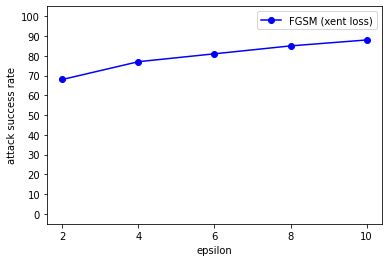

In [43]:
loss_func = 'xent'
epsilons = [2, 4, 6, 8, 10]
attack_success_rates = []

for epsilon in epsilons:
    fgsm_attack = FGSMAttack(model, epsilon, loss_func)
    correct_predictions = evaluate(model, sess, eval_data, correct_indices, attack_method=fgsm_attack)
    attack_success_rate = np.mean(1-correct_predictions)*100
    attack_success_rates.append(attack_success_rate)
    print('Epsilon: {}, Attack success rate: {:.1f}%'.format(epsilon, attack_success_rate))

plt.plot(epsilons, attack_success_rates, '-bo', label='FGSM (xent loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();

## Evaluating the performance of FGSM with Carlini-Wagner loss

In this section, you will evaluate the performance of FGSM using Carlini-Wagner loss. Repeat the procedure in the previous section and compare the results.

If correctly implemented, the success rate will be 80% or higher on epsilon 8.

Epsilon: 2, Attack success rate: 71.0%
Epsilon: 4, Attack success rate: 80.0%
Epsilon: 6, Attack success rate: 85.0%
Epsilon: 8, Attack success rate: 85.0%
Epsilon: 10, Attack success rate: 90.0%


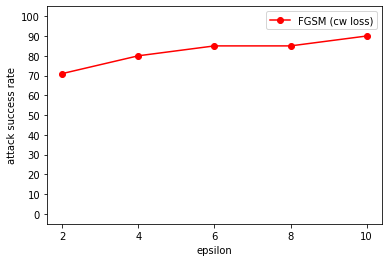

In [59]:
loss_func = 'cw'
epsilons = [2, 4, 6, 8, 10]
attack_success_rates = []

for epsilon in epsilons:
    fgsm_attack = FGSMAttack(model, epsilon, loss_func)
    correct_predictions = evaluate(model, sess, eval_data, correct_indices, attack_method=fgsm_attack)
    attack_success_rate = np.mean(1-correct_predictions)*100
    attack_success_rates.append(attack_success_rate)
    print('Epsilon: {}, Attack success rate: {:.1f}%'.format(epsilon, attack_success_rate))

plt.plot(epsilons, attack_success_rates, '-ro', label='FGSM (cw loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();

## Projected Gradient Descent (PGD)

Next, you will implement Projected Gradient Descent under $\ell_{\infty}$ constraint, which is considered as the strongest white-box attack method proposed by [Madry et al.](https://arxiv.org/abs/1706.06083). The algorithm is as follows.

<center>$x^0 = x$</center>
<center>$x^{t+1} = \prod_{B_{\infty}(x, \epsilon)} [x^{t} + \alpha \cdot \text{sgn}(\nabla_{x} L(x^{t}, y, \theta))]$</center>

where $x, y$ are an image and the corresponding label, $L$ is a loss function, $\alpha$ is a step size, $\epsilon$ is a maximum perturbation, and $B_{\infty}(x, \epsilon)$ is a $\ell_\infty$ ball of radius $\epsilon$ centered at $x$.

Your code for this section will all be written inside `attacks/pgd_attack.py`.

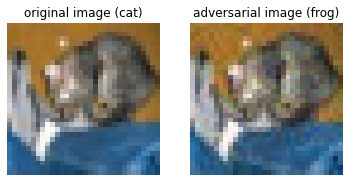

In [62]:
# First implement Projected Gradient Descent.
# Open attacks/pgd_attack.py and follow instructions in the file.

from attacks.pgd_attack import PGDAttack

# Check if your implementation is correct.

# Default attack setting
epsilon = 8
step_size = 2
num_steps = 20
loss_func = 'xent'

# Create an instance of FGSMAttack
pgd_attack = PGDAttack(model, epsilon, step_size, num_steps, loss_func)

# Run PGD attack on a sample
sample_image = eval_data.xs[correct_indices[0]]
sample_image = np.int32(sample_image) # please convert uint8 to int32
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = eval_data.ys[correct_indices[0]]
sample_label = np.expand_dims(sample_label, axis=0)
sample_adv_image = pgd_attack.perturb(sample_image, sample_label, sess)
sample_adv_label = sess.run(model.predictions, feed_dict={model.x_input: sample_adv_image})

# Check if the adversarial image is valid
assert np.amax(np.abs(sample_image-sample_adv_image)) <= epsilon
assert np.amin(sample_adv_image) >= 0
assert np.amax(sample_adv_image) <= 255

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0, ...].astype('uint8'))
plt.axis('off')
plt.title('original image ({})'.format(classes[sample_label[0]]))

# Plot the adversarial image
plt.subplot(1, 2, 2)
plt.imshow(sample_adv_image[0, ...].astype('uint8'))
plt.axis('off')
plt.title('adversarial image ({})'.format(classes[sample_adv_label[0]]));

## Evaluating the performance of PGD with varying $\epsilon$

Now, you will evaluate the performance of PGD with varying maximum perturbation $\epsilon \in [2, 4, 6, 8, 10]$. In this section, you will use Cross-Entropy loss as $L$. Step size and the number of iterations are set to 2 and 20 respectively. The procedure is as follows.

1. First, create an instance of PGDAttack with given $\epsilon$.
2. Evaluate the performance of the attack instance over the samples specified by the variable `correct_indices`.
3. Calculate attack success rate, which is defined by
<center>$\text{attack success rate (%)}=\frac{\text{# samples that are successfully fooled}}{\text{# samples}}\times 100$</center>
4. Run 1, 2, and 3 for each $\epsilon\in [2, 4, 6, 8, 10]$ and draw a plot of attack success rate against $\epsilon$.

If correctly implemented, the success rate will be 100% on epsilon 8.

Epsilon: 2, Attack success rate: 91.0%
Epsilon: 4, Attack success rate: 100.0%
Epsilon: 6, Attack success rate: 100.0%
Epsilon: 8, Attack success rate: 100.0%
Epsilon: 10, Attack success rate: 100.0%


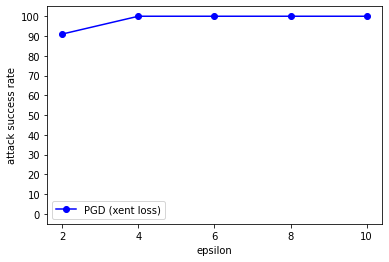

In [63]:
step_size = 2
num_steps = 20
loss_func = 'xent'
epsilons = [2, 4, 6, 8, 10]
attack_success_rates = []

for epsilon in epsilons:
    pgd_attack = PGDAttack(model, epsilon, step_size, num_steps, loss_func)
    correct_predictions = evaluate(model, sess, eval_data, correct_indices, attack_method=pgd_attack)
    attack_success_rate = np.mean(1-correct_predictions)*100
    attack_success_rates.append(attack_success_rate)
    print('Epsilon: {}, Attack success rate: {:.1f}%'.format(epsilon, attack_success_rate))

plt.plot(epsilons, attack_success_rates, '-bo', label='PGD (xent loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();

## Evaluating the performance of PGD with Carlini-Wagner loss

In this section, you will evaluate the performance of PGD using Carlini-Wagner loss. Repeat the procedure in the previous section and compare the results.

If correctly implemented, the success rate will be 100% on epsilon 8.

Epsilon: 2, Attack success rate: 93.0%
Epsilon: 4, Attack success rate: 100.0%
Epsilon: 6, Attack success rate: 100.0%
Epsilon: 8, Attack success rate: 100.0%
Epsilon: 10, Attack success rate: 100.0%


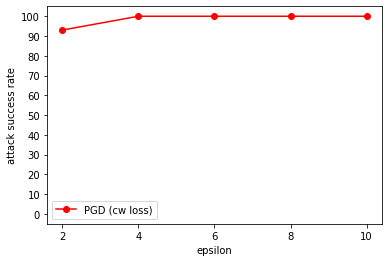

In [64]:
step_size = 2
num_steps = 20
loss_func = 'cw'
epsilons = [2, 4, 6, 8, 10]
attack_success_rates = []

for epsilon in epsilons:
    pgd_attack = PGDAttack(model, epsilon, step_size, num_steps, loss_func)
    correct_predictions = evaluate(model, sess, eval_data, correct_indices, attack_method=pgd_attack)
    attack_success_rate = np.mean(1-correct_predictions)*100
    attack_success_rates.append(attack_success_rate)
    print('Epsilon: {}, Attack success rate: {:.1f}%'.format(epsilon, attack_success_rate))

plt.plot(epsilons, attack_success_rates, '-ro', label='PGD (cw loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();

**Inline Question**

Which is better, Cross-Entropy loss or Carlini-Wagner loss?

**Your Answer**

None

## Attacks on adversarially-trained model

As you can see, naturally-trained neural networks are vulnerable to adversarial attacks. There are several ways to improve adversarial robustness of neural networks. One example is adversarial training, which uses adversarial samples to train a neural network. It constitutes the current state-of-the-art in the adversarial robustness.

PGD adversarial training, proposed by [Madry et al.](https://arxiv.org/abs/1706.06083), utilizes Projected Gradient Descent to train a network. It has been shown that PGD adversarial training on MNIST and Cifar-10 can defend white-box attack successfully.

In [65]:
# Reset all graphs and session
print('Clearing all graphs')
tf.reset_default_graph()

# Create a naturally-trained model
print('Creating a ResNet model')
model = Model(mode='eval')
sess = tf.Session()

# Restore parameters
print('Restoring parameters')
ADV_MODEL_DIR = './models/adv_trained'
model_file = tf.train.latest_checkpoint(ADV_MODEL_DIR)

var_list = {}
with tf.variable_scope('', reuse=True):
  for var in tf.train.list_variables(model_file)[1:]:
    if 'Momentum' not in var[0]:
      var_list[var[0]] = tf.get_variable(name=var[0].replace('BatchNorm', 'batch_normalization'))

saver = tf.train.Saver(var_list=var_list)
saver.restore(sess, model_file)

Clearing all graphs
Creating a ResNet model
Restoring parameters
INFO:tensorflow:Restoring parameters from ./models/adv_trained/checkpoint-70000


## Evaluating the model

Before implementing attack methods, we have to evaluate the model for the following reasons.
1. To check whether the model is successfuly restored. 
2. To get samples that are correctly classified. We don't have to attack misclassified samples.

Note that the indices of the first 100 samples are stored in a variable named `correct_indices`. You will use it later.

In [66]:
# Evaluate the adversarially-trained model on the first 1000 samples in the test dataset
indices = np.arange(0, 1000)

print('Evaluating adversarially-trained model')
correct_predictions = evaluate(model, sess, eval_data, indices)
accuracy = np.mean(correct_predictions)*100
print('Accuracy: {:.1f}%'.format(accuracy))

# Select the first 100 samples that are correctly classified.
correct_indices = np.where(correct_predictions==1)[0][:100]

Evaluating adversarially-trained model
Accuracy: 87.3%


**Inline Question**

Is the accuracy of adversarially-trained model higher than that of naturally-trained model, or lower? Explain why they are different.

**Your answer**

None

**Useful material**

For those who are curious about this phenomenon, see https://arxiv.org/abs/1805.12152.

## Evaluating the performance of FGSM on adversarially-trained model

Now, we will evaluate the the performance of FGSM on adversarially-trained model. In this section, you will use Cross-Entropy loss as $L$.

Epsilon: 2, Attack success rate: 12.0%
Epsilon: 4, Attack success rate: 21.0%
Epsilon: 6, Attack success rate: 31.0%
Epsilon: 8, Attack success rate: 42.0%
Epsilon: 10, Attack success rate: 48.0%


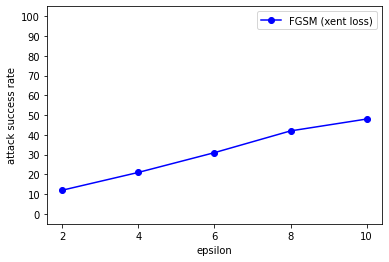

In [67]:
loss_func = 'xent'
epsilons = [2, 4, 6, 8, 10]
fgsm_attack_success_rates = []

for epsilon in epsilons:
    fgsm_attack = FGSMAttack(model, epsilon, loss_func)
    correct_predictions = evaluate(model, sess, eval_data, correct_indices, attack_method=fgsm_attack)
    attack_success_rate = np.mean(1-correct_predictions)*100
    fgsm_attack_success_rates.append(attack_success_rate)
    print('Epsilon: {}, Attack success rate: {:.1f}%'.format(epsilon, attack_success_rate))

plt.plot(epsilons, fgsm_attack_success_rates, '-bo', label='FGSM (xent loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();

## Evaluating the performance of PGD on adversarially-trained model

Now, we will evaluate the the performance of PGD on adversarially-trained model. In this section, you will use Cross-Entropy loss as $L$.

Epsilon: 2, Attack success rate: 12.0%
Epsilon: 4, Attack success rate: 24.0%
Epsilon: 6, Attack success rate: 38.0%
Epsilon: 8, Attack success rate: 52.0%
Epsilon: 10, Attack success rate: 64.0%


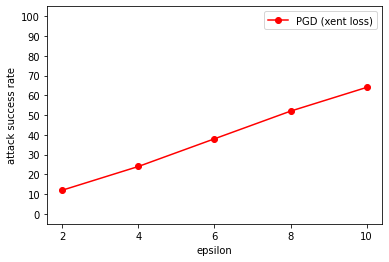

In [68]:
step_size = 2
num_steps = 20
loss_func = 'xent'
epsilons = [2, 4, 6, 8, 10]
pgd_attack_success_rates = []

for epsilon in epsilons:
    pgd_attack = PGDAttack(model, epsilon, step_size, num_steps, loss_func)
    correct_predictions = evaluate(model, sess, eval_data, correct_indices, attack_method=pgd_attack)
    attack_success_rate = np.mean(1-correct_predictions)*100
    pgd_attack_success_rates.append(attack_success_rate)
    print('Epsilon: {}, Attack success rate: {:.1f}%'.format(epsilon, attack_success_rate))

plt.plot(epsilons, pgd_attack_success_rates, '-ro', label='PGD (xent loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();

## Comparing the performance of FGSM and PGD

Finally, we compare the performace of FGSM and PGD on adversarially-trained model. Just overlay the plots drawn in the two previous sections.

In [0]:
epsilons = [2, 4, 6, 8, 10]

plt.plot(epsilons, fgsm_attack_success_rates, '-bo', label='FGSM (xent loss)')
plt.plot(epsilons, pgd_attack_success_rates, '-ro', label='PGD (xent loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();

**Inline question**

Describe the result above.

**Your answer**

None